# Cross-matching of large catalogs: DES to Gaia

In this tutorial we cross-match nain tables of Dark Energy Survey (DES) DR2 and Gaia DR3 catalogs. The outline of the tutorial is as follows:
1. Get original data files
2. Convert the data to HiPSCat format using [`hipscat-import`](https://github.com/astronomy-commons/hipscat-import/)
3. Cross-match the catalogs using LSDB and save to a new HiPSCat catalog

### Install required packages and import modules

In [1]:
import lsdb

# Uncomment to install hipscat-import
# ! pip install --quiet hipscat-import
# ! pip install --quiet git+https://github.com/astronomy-commons/hipscat-import.git@issue/221/gaia

# Uncomment to install lsdb
# ! pip install --quiet lsdb

In [103]:
# For files and directories manipulation
from pathlib import Path

# For Gaia columns data types inference
import pyarrow
from astropy.io import ascii

# Client for Dask distributed computing

from dask.distributed import Client

# For plots
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import numpy as np

# Explore the HiPSCat catalogs and plot sky maps
import hipscat
from hipscat.catalog import Catalog
from hipscat.inspection import plot_pixels

# For reading the HiPSCat catalogs and performing the cross-match
import lsdb

# For converting the data to HiPSCat format
from hipscat_import.catalog.file_readers import CsvReader
from hipscat_import.pipeline import ImportArguments, pipeline_with_client

## Get original data files

??? Do we need to get scripts / Python code to download the data? Maybe one-liner with recursive `wget`?

To make this notebook faster to run and using less storage, we will use a subset of the data. However, the same pipeline, with no code changes, may be used to process the full catalogs.

In [3]:
# Change to the directories where the data will be stored
DES_DIR = Path("data/DES_DR2")
GAIA_DIR = Path("data/Gaia_DR3")

HIPSCAT_DIR = Path("hipscat")
DES_HIPSCAT_DIR = HIPSCAT_DIR / "des_dr2"
GAIA_HIPSCAT_DIR = HIPSCAT_DIR / "gaia_dr3"

OUTPUT_HIPSCAT_DIR = HIPSCAT_DIR / "des_dr2_x_gaia_dr3"

### DES DR2

The Dark Eenrgy Survey DR2 catalog is hosted by NCSA, see the [official website](https://des.ncsa.illinois.edu/releases/dr2) for more information. Data files, in [FITS](https://fits.gsfc.nasa.gov) format, are located at <https://desdr-server.ncsa.illinois.edu/despublic/dr2_tiles/>.

We use `*dr2_main.fits` files for the main catalog table, see [the schema here](https://des.ncsa.illinois.edu/releases/dr2/dr2-products/dr2-schema).

Here we download a few first files to demonstrate the pipeline. The full catalog is much larger, feel free to download it all if you have enough storage.

In [4]:
# Comment / skip this cell if you already have the data

from shutil import copyfileobj

import requests  # For downloading files

# Download few first files
des_urls = [
    "https://desdr-server.ncsa.illinois.edu/despublic/dr2_tiles/DES0000+0209/DES0000+0209_dr2_main.fits",
    "https://desdr-server.ncsa.illinois.edu/despublic/dr2_tiles/DES0000+0252/DES0000+0252_dr2_main.fits",
    "https://desdr-server.ncsa.illinois.edu/despublic/dr2_tiles/DES0000+0335/DES0000+0335_dr2_main.fits",
]

for des_url in des_urls:
    des_file = DES_DIR / Path(des_url).name
    if not des_file.exists():
        des_file.parent.mkdir(parents=True, exist_ok=True)
        with requests.get(des_url, stream=True) as r, open(des_file, "wb") as f:
            copyfileobj(r.raw, f)

### Gaia DR3

The Gaia DR3 catalog is hosted by ESA, see the [official website](https://www.cosmos.esa.int/web/gaia/dr3) for more information. Data files, in [ECSV](https://docs.astropy.org/en/stable/io/ascii/ecsv.html) format are located at <http://cdn.gea.esac.esa.int/Gaia/gdr3/gaia_source/>.

We use `gaia_source` table, see its [schema here](https://gea.esac.esa.int/archive/documentation/GDR3/Gaia_archive/chap_datamodel/sec_dm_main_source_catalogue/ssec_dm_gaia_source.html).

Here we donwload a few files which barely correspond to the same area of the sky as the DES DR2 files above. The full catalog is much larger, feel free to download it all if you have enough storage.

In [5]:
# Comment / skip this cell if you already have the data

from shutil import copyfileobj

import requests  # For downloading files

# Download few first files
gaia_urls = [
    "http://cdn.gea.esac.esa.int/Gaia/gdr3/gaia_source/GaiaSource_310878-313367.csv.gz",
]

for gaia_url in gaia_urls:
    gaia_file = GAIA_DIR / Path(gaia_url).name
    if not gaia_file.exists():
        gaia_file.parent.mkdir(parents=True, exist_ok=True)
        with requests.get(gaia_url, stream=True) as r, open(gaia_file, "wb") as f:
            copyfileobj(r.raw, f)

## Convert the data to HiPSCat format

We use the [`hipscat-import`](https://github.com/astronomy-commons/hipscat-import/) tool to create HiPSCat catalogs from the original data files.

### Convert DES DR2 to HiPSCat

- Plan the pipeline specifying all parameters of the conversion
- Run the pipeline with [Dask](https://dask.org)

In [6]:
des_args = ImportArguments(
    # sort columns are optional and works only if few objects are very close to each other
    sort_columns="COADD_OBJECT_ID",
    ra_column="RA",
    dec_column="DEC",
    input_path=DES_DIR,
    input_format="fits",
    output_artifact_name="des_dr2",
    output_path=HIPSCAT_DIR,
    # Uncomment to overwrite existing catalog
    overwrite=True,
)

with Client() as client:
    pipeline_with_client(des_args, client)

Finishing : 100%|██████████| 5/5 [00:00<00:00, 201.67it/s]


#### Plot the DES DR2 HiPSCat catalog pixels

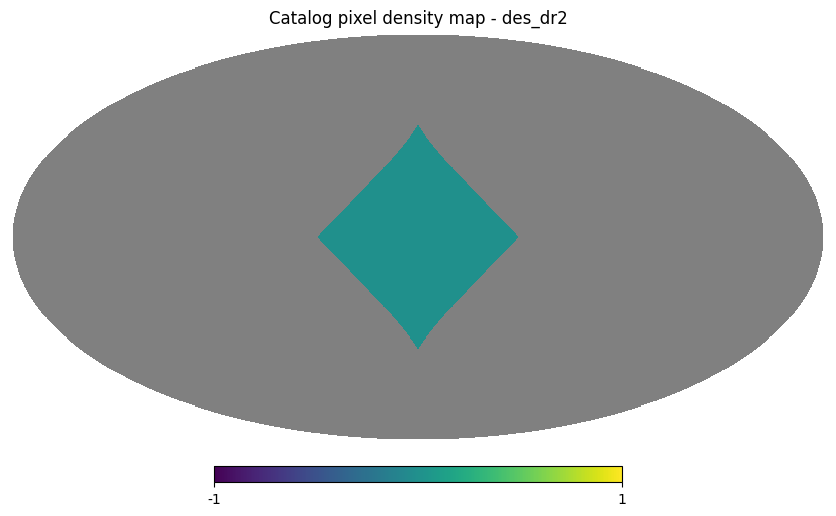

In [7]:
# Read the HiPSCat catalog metadata, it does not load any data, just healpix pixels and other metadata
des_hipscat_catalog = Catalog.read_from_hipscat(DES_HIPSCAT_DIR)
plot_pixels(des_hipscat_catalog)

# TODO: add DES footprint to this plot
# https://des.ncsa.illinois.edu/static/images/dr2/dr2_footprint.png

### Convert Gaia DR3 to HiPSCat

For Gaia we need to specify schema of the input data, because currently `hipscat-import` cannot infer column data types properly from this dataset.

See this GitHub issue for more details: <https://github.com/astronomy-commons/hipscat-import/issues/225>

In [8]:
empty_astropy_table = ascii.read(gaia_file, format="ecsv", data_end=1)

# table_dtypes = {name: empty_astropy_table[name].dtype for name in empty_astropy_table.colnames}
# parquet_schema = pyarrow.schema(pyarrow.field(name, pyarrow.from_numpy_dtype(dtype), nullable=True) for name, dtype in table_dtypes.items())
# pyarrow.parquet.ParquetWriter(GAIA_DIR / 'schema.parquet', parquet_schema).close()

# empty_astropy_table.to_pandas().to_parquet(GAIA_DIR / "schema.parquet")
empty_astropy_table.write(GAIA_DIR / "schema.parquet", overwrite=True)

In [9]:
gaia_args = ImportArguments(
    # sort columns are optional and works only if few objects are very close to each other
    sort_columns="source_id",
    ra_column="ra",
    dec_column="dec",
    input_path=GAIA_DIR,
    input_format="csv.gz",
    file_reader=CsvReader(
        comment="#",
        # We need str() here, see
        # https://github.com/astronomy-commons/hipscat-import/issues/228
        schema_file=str(GAIA_DIR / "schema.parquet"),
        parquet_kwargs={"dtype_backend": "numpy_nullable"},
    ),
    use_schema_file=GAIA_DIR / "schema.parquet",
    output_artifact_name="gaia_dr3",
    output_path=HIPSCAT_DIR,
    # Uncomment to overwrite existing catalog
    overwrite=True,
)

with Client() as client:
    pipeline_with_client(gaia_args, client)

Finishing : 100%|██████████| 5/5 [00:00<00:00, 273.58it/s]


#### Plot the Gaia DR3 HiPSCat catalog pixels

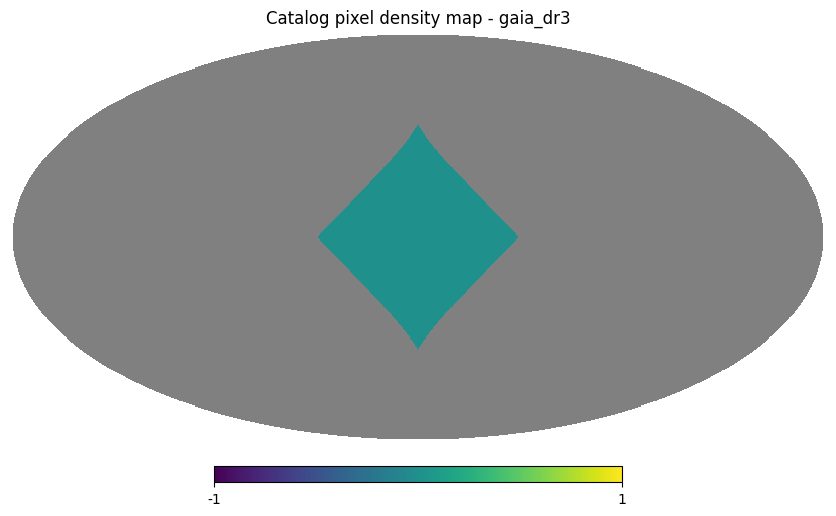

In [10]:
# It should be full sky for the whole catalog
gaia_hipscat_catalog = Catalog.read_from_hipscat(GAIA_HIPSCAT_DIR)
plot_pixels(gaia_hipscat_catalog)

### Cross-match the catalogs

!!!! talk about margin caches

!!!! Talk about many-to-one matching

- Plan the pipeline with LSDB
- Run the pipeline with [Dask](https://dask.org)

In [11]:
des_catalog = lsdb.read_hipscat(DES_HIPSCAT_DIR)
gaia_catalog = lsdb.read_hipscat(GAIA_HIPSCAT_DIR)
xmatched = des_catalog.crossmatch(
    gaia_catalog,
    # Up to 1 arcsec distance, it is the default
    radius_arcsec=1.0,
    # Single closest object, it is the default
    n_neighbors=1,
    # Default would be to use names of the HiPSCat catalogs
    suffixes=("_des", "_gaia"),
)

display(des_catalog)
display(gaia_catalog)
display(xmatched)

/Users/hombit/projects/lincc-frameworks/lsdb/src/lsdb/dask/crossmatch_catalog_data.py:101: RuntimeWarning: Right catalog does not have a margin cache. Results may be inaccurate
  warnings.warn("Right catalog does not have a margin cache. Results may be inaccurate", RuntimeWarning)


,COADD_OBJECT_ID,TILENAME,HPIX_32,HPIX_64,HPIX_1024,HPIX_4096,HPIX_16384,RA,DEC,ALPHAWIN_J2000,DELTAWIN_J2000,GALACTIC_L,GALACTIC_B,XWIN_IMAGE,YWIN_IMAGE,A_IMAGE,ERRA_IMAGE,B_IMAGE,ERRB_IMAGE,THETA_J2000,ERRTHETA_IMAGE,KRON_RADIUS,EBV_SFD98,MAG_AUTO_G_DERED,MAG_AUTO_R_DERED,MAG_AUTO_I_DERED,MAG_AUTO_Z_DERED,MAG_AUTO_Y_DERED,WAVG_MAG_PSF_G_DERED,WAVG_MAG_PSF_R_DERED,WAVG_MAG_PSF_I_DERED,WAVG_MAG_PSF_Z_DERED,WAVG_MAG_PSF_Y_DERED,EXTENDED_CLASS_COADD,EXTENDED_CLASS_WAVG,FLAGS_G,IMAFLAGS_ISO_G,NEPOCHS_G,FLAGS_R,IMAFLAGS_ISO_R,NEPOCHS_R,FLAGS_I,IMAFLAGS_ISO_I,NEPOCHS_I,FLAGS_Z,IMAFLAGS_ISO_Z,NEPOCHS_Z,FLAGS_Y,IMAFLAGS_ISO_Y,NEPOCHS_Y,XWIN_IMAGE_G,XWIN_IMAGE_R,XWIN_IMAGE_I,XWIN_IMAGE_Z,XWIN_IMAGE_Y,YWIN_IMAGE_G,YWIN_IMAGE_R,YWIN_IMAGE_I,YWIN_IMAGE_Z,YWIN_IMAGE_Y,X2WIN_IMAGE_G,X2WIN_IMAGE_R,X2WIN_IMAGE_I,X2WIN_IMAGE_Z,X2WIN_IMAGE_Y,Y2WIN_IMAGE_G,Y2WIN_IMAGE_R,Y2WIN_IMAGE_I,Y2WIN_IMAGE_Z,Y2WIN_IMAGE_Y,XYWIN_IMAGE_G,XYWIN_IMAGE_R,XYWIN_IMAGE_I,XYWIN_IMAGE_Z,XYWIN_IMAGE_Y,ERRX2WIN_IMAGE_G,ERRX2WIN_IMAGE_R,ERRX2WIN_IMAGE_I,ERRX2WIN_IMAGE_Z,ERRX2WIN_IMAGE_Y,ERRY2WIN_IMAGE_G,ERRY2WIN_IMAGE_R,ERRY2WIN_IMAGE_I,ERRY2WIN_IMAGE_Z,ERRY2WIN_IMAGE_Y,ERRXYWIN_IMAGE_G,ERRXYWIN_IMAGE_R,ERRXYWIN_IMAGE_I,ERRXYWIN_IMAGE_Z,ERRXYWIN_IMAGE_Y,AWIN_IMAGE_G,AWIN_IMAGE_R,AWIN_IMAGE_I,AWIN_IMAGE_Z,AWIN_IMAGE_Y,BWIN_IMAGE_G,BWIN_IMAGE_R,BWIN_IMAGE_I,BWIN_IMAGE_Z,BWIN_IMAGE_Y,THETAWIN_IMAGE_G,THETAWIN_IMAGE_R,THETAWIN_IMAGE_I,THETAWIN_IMAGE_Z,THETAWIN_IMAGE_Y,ERRAWIN_IMAGE_G,ERRAWIN_IMAGE_R,ERRAWIN_IMAGE_I,ERRAWIN_IMAGE_Z,ERRAWIN_IMAGE_Y,ERRBWIN_IMAGE_G,ERRBWIN_IMAGE_R,ERRBWIN_IMAGE_I,ERRBWIN_IMAGE_Z,ERRBWIN_IMAGE_Y,ERRTHETAWIN_IMAGE_G,ERRTHETAWIN_IMAGE_R,ERRTHETAWIN_IMAGE_I,ERRTHETAWIN_IMAGE_Z,ERRTHETAWIN_IMAGE_Y,FLUX_RADIUS_G,FLUX_RADIUS_R,FLUX_RADIUS_I,FLUX_RADIUS_Z,FLUX_RADIUS_Y,FWHM_IMAGE_G,FWHM_IMAGE_R,FWHM_IMAGE_I,FWHM_IMAGE_Z,FWHM_IMAGE_Y,ISOAREA_IMAGE_G,ISOAREA_IMAGE_R,ISOAREA_IMAGE_I,ISOAREA_IMAGE_Z,ISOAREA_IMAGE_Y,BACKGROUND_G,BACKGROUND_R,BACKGROUND_I,BACKGROUND_Z,BACKGROUND_Y,NITER_MODEL_G,NITER_MODEL_R,NITER_MODEL_I,NITER_MODEL_Z,NITER_MODEL_Y,KRON_RADIUS_G,KRON_RADIUS_R,KRON_RADIUS_I,KRON_RADIUS_Z,KRON_RADIUS_Y,MAG_AUTO_G,MAG_AUTO_R,MAG_AUTO_I,MAG_AUTO_Z,MAG_AUTO_Y,MAGERR_AUTO_G,MAGERR_AUTO_R,MAGERR_AUTO_I,MAGERR_AUTO_Z,MAGERR_AUTO_Y,WAVG_MAG_PSF_G,WAVG_MAG_PSF_R,WAVG_MAG_PSF_I,WAVG_MAG_PSF_Z,WAVG_MAG_PSF_Y,WAVG_MAGERR_PSF_G,WAVG_MAGERR_PSF_R,WAVG_MAGERR_PSF_I,WAVG_MAGERR_PSF_Z,WAVG_MAGERR_PSF_Y,FLUX_AUTO_G,FLUX_AUTO_R,FLUX_AUTO_I,FLUX_AUTO_Z,FLUX_AUTO_Y,FLUXERR_AUTO_G,FLUXERR_AUTO_R,FLUXERR_AUTO_I,FLUXERR_AUTO_Z,FLUXERR_AUTO_Y,WAVG_FLUX_PSF_G,WAVG_FLUX_PSF_R,WAVG_FLUX_PSF_I,WAVG_FLUX_PSF_Z,WAVG_FLUX_PSF_Y,WAVG_FLUXERR_PSF_G,WAVG_FLUXERR_PSF_R,WAVG_FLUXERR_PSF_I,WAVG_FLUXERR_PSF_Z,WAVG_FLUXERR_PSF_Y,CLASS_STAR_G,CLASS_STAR_R,CLASS_STAR_I,CLASS_STAR_Z,CLASS_STAR_Y,SPREAD_MODEL_G,SPREAD_MODEL_R,SPREAD_MODEL_I,SPREAD_MODEL_Z,SPREAD_MODEL_Y,WAVG_SPREAD_MODEL_G,WAVG_SPREAD_MODEL_R,WAVG_SPREAD_MODEL_I,WAVG_SPREAD_MODEL_Z,WAVG_SPREAD_MODEL_Y,SPREADERR_MODEL_G,SPREADERR_MODEL_R,SPREADERR_MODEL_I,SPREADERR_MODEL_Z,SPREADERR_MODEL_Y,WAVG_SPREADERR_MODEL_G,WAVG_SPREADERR_MODEL_R,WAVG_SPREADERR_MODEL_I,WAVG_SPREADERR_MODEL_Z,WAVG_SPREADERR_MODEL_Y,Norder,Dir,Npix
npartitions=1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4611686018427387904,int64,string,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int16,int16,int16,int32,int32,int16,int32,int32,int16,int32,int32,int16,int32,int32,int16,int32,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64

,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pm,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,nu_eff_used_in_astrometry,pseudocolour,pseudocolour_error,ra_pseudocolour_corr,dec_pseudocolour_corr,parallax_pseudocolour_corr,pmra_pseudocolour_corr,pmdec_pseudocolour_corr,astrometric_matched_transits,visibility_periods_used,astrometric_sigma5d_max,matched_transits,new_matched_transits,matched_transits_removed,ipd_gof_harmonic_amplitude,ipd_gof_harmonic_phase,ipd_frac_multi_peak,ipd_frac_odd_win,ruwe,scan_direction_strength_k1,scan_direction_strength_k2,scan_direction_strength_k3,scan_direction_strength_k4,scan_direction_mean_k1,scan_direction_mean_k2,scan_direction_mean_k3,scan_direction_mean_k4,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_bp_n_contaminated_transits,phot_bp_n_blended_transits,phot_rp_n_contaminated_transits,phot_rp_n_blended_transits,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_method_used,rv_nb_transits,rv_nb_deblended_transits,rv_visibility_periods_used,rv_expected_sig_to_noise,rv_renormalised_gof,rv_chisq_pvalue,rv_time_duration,rv_amplitude_robust,rv_template_teff,rv_template_logg,rv_template_fe_h,rv_atm_param_origin,vbroad,vbroad_error,vbroad_nb_transits,grvs_mag,grvs_mag_error,grvs_mag_nb_transits,rvs_spec_sig_to_noise,phot_variable_flag,l,b,ecl_lon,ecl_lat,in_qso_candidates,in_galaxy_candidates,non_single_star,has_xp_continuous,has_xp_sampled,has_rvs,has_epoch_photometry,has_epoch_rv,has_mcmc_gspphot,has_mcmc_msc,in_andromeda_survey,classprob_dsc_combmod_quasar,classprob_dsc_combmod_galaxy,classprob_dsc_combmod_star,teff_gspphot,teff_gspphot_lower,teff_gspphot_upper,logg_gspphot,logg_gspphot_lower,logg_gspphot_upper,mh_gspphot,mh_gspphot_lower,mh_gspphot_upper,distance_gspphot,distance_gspphot_lower,distance_gspphot_upper,azero_gspphot,azero_gspphot_lower,azero_gspphot_upper,ag_gspphot,ag_gspphot_lower,ag_gspphot_upper,ebpminrp_gspphot,ebpminrp_gspphot_lower,ebpminrp_gspphot_upper,libname_gspphot,Norder,Dir,Npix
npartitions=1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4611686018427387904,int64,string,int64,int64,float64,float64,float32,float64,float32,float64,float32,float32,float32,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,int16,float32,float32,float32,float32,int8,bool,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,float32,int16,int16,int16,float32,float32,int8,int8,float32,float32,float32,float32,float32,float32,float32,float32,float32,bool,int16,float64,float32,float32,float32,int16,float64,float32,float32,float32,int16,float64,float32,float32,float32,float32,int16,int16,int16,int16,int8,float32,float32,float32,float32,float32,int8,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,int16,float32,float32,int16,float32,string,float64,float64,float64,float64,bool,bool,int16,bool,bool,bool,bool,bool,bool,bool,bool,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,f

,COADD_OBJECT_ID_des,TILENAME_des,HPIX_32_des,HPIX_64_des,HPIX_1024_des,HPIX_4096_des,HPIX_16384_des,RA_des,DEC_des,ALPHAWIN_J2000_des,DELTAWIN_J2000_des,GALACTIC_L_des,GALACTIC_B_des,XWIN_IMAGE_des,YWIN_IMAGE_des,A_IMAGE_des,ERRA_IMAGE_des,B_IMAGE_des,ERRB_IMAGE_des,THETA_J2000_des,ERRTHETA_IMAGE_des,KRON_RADIUS_des,EBV_SFD98_des,MAG_AUTO_G_DERED_des,MAG_AUTO_R_DERED_des,MAG_AUTO_I_DERED_des,MAG_AUTO_Z_DERED_des,MAG_AUTO_Y_DERED_des,WAVG_MAG_PSF_G_DERED_des,WAVG_MAG_PSF_R_DERED_des,WAVG_MAG_PSF_I_DERED_des,WAVG_MAG_PSF_Z_DERED_des,WAVG_MAG_PSF_Y_DERED_des,EXTENDED_CLASS_COADD_des,EXTENDED_CLASS_WAVG_des,FLAGS_G_des,IMAFLAGS_ISO_G_des,NEPOCHS_G_des,FLAGS_R_des,IMAFLAGS_ISO_R_des,NEPOCHS_R_des,FLAGS_I_des,IMAFLAGS_ISO_I_des,NEPOCHS_I_des,FLAGS_Z_des,IMAFLAGS_ISO_Z_des,NEPOCHS_Z_des,FLAGS_Y_des,IMAFLAGS_ISO_Y_des,NEPOCHS_Y_des,XWIN_IMAGE_G_des,XWIN_IMAGE_R_des,XWIN_IMAGE_I_des,XWIN_IMAGE_Z_des,XWIN_IMAGE_Y_des,YWIN_IMAGE_G_des,YWIN_IMAGE_R_des,YWIN_IMAGE_I_des,YWIN_IMAGE_Z_des,YWIN_IMAGE_Y_des,X2WIN_IMAGE_G_des,X2WIN_IMAGE_R_des,X2WIN_IMAGE_I_des,X2WIN_IMAGE_Z_des,X2WIN_IMAGE_Y_des,Y2WIN_IMAGE_G_des,Y2WIN_IMAGE_R_des,Y2WIN_IMAGE_I_des,Y2WIN_IMAGE_Z_des,Y2WIN_IMAGE_Y_des,XYWIN_IMAGE_G_des,XYWIN_IMAGE_R_des,XYWIN_IMAGE_I_des,XYWIN_IMAGE_Z_des,XYWIN_IMAGE_Y_des,ERRX2WIN_IMAGE_G_des,ERRX2WIN_IMAGE_R_des,ERRX2WIN_IMAGE_I_des,ERRX2WIN_IMAGE_Z_des,ERRX2WIN_IMAGE_Y_des,ERRY2WIN_IMAGE_G_des,ERRY2WIN_IMAGE_R_des,ERRY2WIN_IMAGE_I_des,ERRY2WIN_IMAGE_Z_des,ERRY2WIN_IMAGE_Y_des,ERRXYWIN_IMAGE_G_des,ERRXYWIN_IMAGE_R_des,ERRXYWIN_IMAGE_I_des,ERRXYWIN_IMAGE_Z_des,ERRXYWIN_IMAGE_Y_des,AWIN_IMAGE_G_des,AWIN_IMAGE_R_des,AWIN_IMAGE_I_des,AWIN_IMAGE_Z_des,AWIN_IMAGE_Y_des,BWIN_IMAGE_G_des,BWIN_IMAGE_R_des,BWIN_IMAGE_I_des,BWIN_IMAGE_Z_des,BWIN_IMAGE_Y_des,THETAWIN_IMAGE_G_des,THETAWIN_IMAGE_R_des,THETAWIN_IMAGE_I_des,THETAWIN_IMAGE_Z_des,THETAWIN_IMAGE_Y_des,ERRAWIN_IMAGE_G_des,ERRAWIN_IMAGE_R_des,ERRAWIN_IMAGE_I_des,ERRAWIN_IMAGE_Z_des,ERRAWIN_IMAGE_Y_des,ERRBWIN_IMAGE_G_des,ERRBWIN_IMAGE_R_des,ERRBWIN_IMAGE_I_des,ERRBWIN_IMAGE_Z_des,ERRBWIN_IMAGE_Y_des,ERRTHETAWIN_IMAGE_G_des,ERRTHETAWIN_IMAGE_R_des,ERRTHETAWIN_IMAGE_I_des,ERRTHETAWIN_IMAGE_Z_des,ERRTHETAWIN_IMAGE_Y_des,FLUX_RADIUS_G_des,FLUX_RADIUS_R_des,FLUX_RADIUS_I_des,FLUX_RADIUS_Z_des,FLUX_RADIUS_Y_des,FWHM_IMAGE_G_des,FWHM_IMAGE_R_des,FWHM_IMAGE_I_des,FWHM_IMAGE_Z_des,FWHM_IMAGE_Y_des,ISOAREA_IMAGE_G_des,ISOAREA_IMAGE_R_des,ISOAREA_IMAGE_I_des,ISOAREA_IMAGE_Z_des,ISOAREA_IMAGE_Y_des,BACKGROUND_G_des,BACKGROUND_R_des,BACKGROUND_I_des,BACKGROUND_Z_des,BACKGROUND_Y_des,NITER_MODEL_G_des,NITER_MODEL_R_des,NITER_MODEL_I_des,NITER_MODEL_Z_des,NITER_MODEL_Y_des,KRON_RADIUS_G_des,KRON_RADIUS_R_des,KRON_RADIUS_I_des,KRON_RADIUS_Z_des,KRON_RADIUS_Y_des,MAG_AUTO_G_des,MAG_AUTO_R_des,MAG_AUTO_I_des,MAG_AUTO_Z_des,MAG_AUTO_Y_des,MAGERR_AUTO_G_des,MAGERR_AUTO_R_des,MAGERR_AUTO_I_des,MAGERR_AUTO_Z_des,MAGERR_AUTO_Y_des,WAVG_MAG_PSF_G_des,WAVG_MAG_PSF_R_des,WAVG_MAG_PSF_I_des,WAVG_MAG_PSF_Z_des,WAVG_MAG_PSF_Y_des,WAVG_MAGERR_PSF_G_des,WAVG_MAGERR_PSF_R_des,WAVG_MAGERR_PSF_I_des,WAVG_MAGERR_PSF_Z_des,WAVG_MAGERR_PSF_Y_des,FLUX_AUTO_G_des,FLUX_AUTO_R_des,FLUX_AUTO_I_des,FLUX_AUTO_Z_des,FLUX_AUTO_Y_des,FLUXERR_AUTO_G_des,FLUXERR_AUTO_R_des,FLUXERR_AUTO_I_des,FLUXERR_AUTO_Z_des,FLUXERR_AUTO_Y_des,WAVG_FLUX_PSF_G_des,WAVG_FLUX_PSF_R_des,WAVG_FLUX_PSF_I_des,WAVG_FLUX_PSF_Z_des,WAVG_FLUX_PSF_Y_des,WAVG_FLUXERR_PSF_G_des,WAVG_FLUXERR_PSF_R_des,WAVG_FLUXERR_PSF_I_des,WAVG_FLUXERR_PSF_Z_des,WAVG_FLUXERR_PSF_Y_des,CLASS_STAR_G_des,CLASS_STAR_R_des,CLASS_STAR_I_des,CLASS_STAR_Z_des,CLASS_STAR_Y_des,SPREAD_MODEL_G_des,SPREAD_MODEL_R_des,SPREAD_MODEL_I_des,SPREAD_MODEL_Z_des,SPREAD_MODEL_Y_des,WAVG_SPREAD_MODEL_G_des,WAVG_SPREAD_MODEL_R_des,WAVG_SPREAD_MODEL_I_des,WAVG_SPREAD_MODEL_Z_des,WAVG_SPREAD_MODEL_Y_des,SPREADERR_MODEL_G_des,SPREADERR_MODEL_R_des,SPREADERR_MODEL_I_des,SPREADERR_MODEL_Z_des,SPREADERR_MODEL_Y_des,WAVG_SPREADERR_MODEL_G_des,WAVG_SPREADERR_MODEL_R_des,WAVG_SPREADERR_MODEL_I_des,WAVG_SPREADERR_MODEL_Z

In [12]:
with Client():
    # We neen str() here, see
    # https://github.com/astronomy-commons/lsdb/issues/169
    xmatched.to_hipscat(str(OUTPUT_HIPSCAT_DIR))

In [14]:
#### Look into the data
lsdb.read_hipscat(OUTPUT_HIPSCAT_DIR).head()

,COADD_OBJECT_ID_des,TILENAME_des,HPIX_32_des,HPIX_64_des,HPIX_1024_des,HPIX_4096_des,HPIX_16384_des,RA_des,DEC_des,ALPHAWIN_J2000_des,...,ag_gspphot_lower_gaia,ag_gspphot_upper_gaia,ebpminrp_gspphot_gaia,ebpminrp_gspphot_lower_gaia,ebpminrp_gspphot_upper_gaia,libname_gspphot_gaia,Norder_gaia,Dir_gaia,Npix_gaia,_DIST
_hipscat_index,,,,,,,,,,,,,,,,,,,,,
5477333554734039040,1033365960,DES0000+0209,4864,19459,4981605,79705693,1275291097,0.315738,1.807978,0.315738,...,0.1502,0.1595,0.0839,0.0812,0.0863,MARCS,0,0,4,6.045534e-05
5477333571859382272,1033367823,DES0000+0209,4864,19459,4981605,79705693,1275291101,0.321042,1.812476,0.321042,...,0.1019,0.1442,0.0686,0.0556,0.0787,A,0,0,4,9.228876e-07
5477333673311207424,1033367955,DES0000+0209,4864,19459,4981605,79705695,1275291124,0.310521,1.816329,0.310521,...,NaN,NaN,NaN,NaN,NaN,<NA>,0,0,4,2.103963e-06
5477334253035323392,1033369594,DES0000+0209,4864,19459,4981606,79705703,1275291259,0.234549,1.802340,0.234549,...,NaN,NaN,NaN,NaN,NaN,<NA>,0,0,4,2.801105e-06
5477334650319798272,1033369151,DES0000+0209,4864,19459,4981606,79705709,1275291352,0.224895,1.805816,0.224895,...,NaN,NaN,NaN,NaN,NaN,<NA>,0,0,4,1.625510e-06


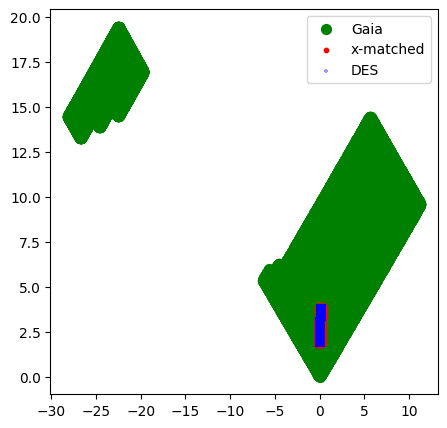

In [81]:
ra_range = [0.0, 0.1]
dec_range = [2.45, 2.55]

des_box = des_catalog.box(ra=ra_range, dec=dec_range).compute()
gaia_box = gaia_catalog.box(ra=ra_range, dec=dec_range).compute()
xmatch_box = xmatched.box(ra=ra_range, dec=dec_range).compute()

des_box = des_catalog.compute()
gaia_box = gaia_catalog.compute()
xmatch_box = xmatched.compute()

ra_des = np.where(des_box["RA"] > 180, des_box["RA"] - 360, des_box["RA"])
ra_gaia = np.where(gaia_box["ra"] > 180, gaia_box["ra"] - 360, gaia_box["ra"])
ra_x_gaia = np.where(xmatch_box["ra_gaia"] > 180, xmatch_box["ra_gaia"] - 360, xmatch_box["ra_gaia"])

plt.figure(figsize=(5, 5))
plt.scatter(ra_gaia, gaia_box["dec"], s=50, alpha=1.0, color="green", label="Gaia")
plt.scatter(ra_x_gaia, xmatch_box["dec_gaia"], s=10, alpha=1.0, color="red", label="x-matched")
plt.scatter(ra_des, des_box["DEC"], s=10, alpha=0.4, marker="+", color="blue", label="DES")
plt.legend()

Text(0.5, 1.0, 'Color — absolute magnitude diagram')

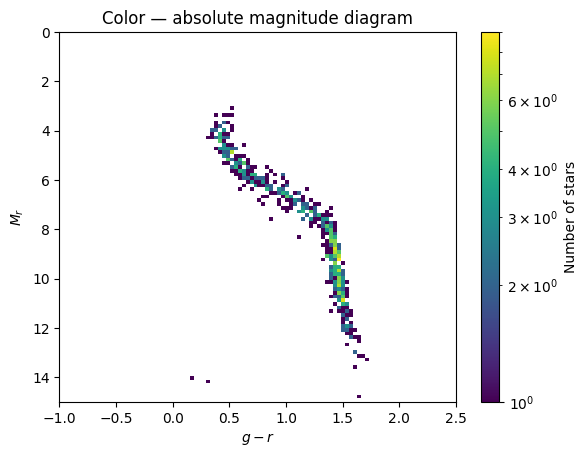

In [106]:
# dask data frame
ddf = xmatched.query(
    "parallax_over_error_gaia > 10.0 and WAVG_MAG_PSF_G_des > 0.0 and WAVG_MAG_PSF_R_des > 0.0"
)._ddf

# get 2D histogram of WAVG_MAG_PSF_R-WAVG_MAG_PSF_I vs WAVG_MAG_PSF_I, lazily
color = ddf["WAVG_MAG_PSF_G_des"] - ddf["WAVG_MAG_PSF_R_des"]
absolute_r = ddf["WAVG_MAG_PSF_R_des"] + 5 * np.log10(ddf["parallax_gaia"] / 100)

x_bins = np.linspace(-1, 2.5, 101)
y_bins = np.linspace(0, 15, 101)

hist2d = (
    da.histogram2d(color.to_dask_array(), absolute_r.to_dask_array(), bins=[x_bins, y_bins])[0].compute().T
)
plt.imshow(
    hist2d,
    extent=(x_bins[0], x_bins[-1], y_bins[0], y_bins[-1]),
    aspect="auto",
    origin="lower",
    norm=LogNorm(vmin=1, vmax=hist2d.max()),
)
plt.gca().invert_yaxis()
plt.colorbar(label="Number of stars")
plt.xlabel("$g-r$")
plt.ylabel("$M_r$")
plt.title("Color — absolute magnitude diagram")